In [1]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
#using ProgressMeter
using CUDA
using Test
using BenchmarkTools;

┌ Warning: `haskey(::TargetIterator, name::String)` is deprecated, use `Target(; name = name) !== nothing` instead.
│   caller = llvm_compat(::VersionNumber) at compatibility.jl:176
└ @ CUDAnative C:\Users\jbere\.julia\packages\CUDAnative\ierw8\src\compatibility.jl:176


In [2]:
println(Threads.nthreads())
has_cuda_gpu()

4


┌ Warning: `haskey(::TargetIterator, name::String)` is deprecated, use `Target(; name = name) !== nothing` instead.
│   caller = llvm_compat(::VersionNumber) at compatibility.jl:176
└ @ CUDA C:\Users\jbere\.julia\packages\CUDA\5t6R9\deps\compatibility.jl:176


true

In [3]:
#Hyperparameters
n = 10
N = 40
σₐ = 0.02
k_range = 4
k_list = [i for i in 1:k_range];

In [18]:
#Functions
function plot_data(data,classes,alpha=1.0)
    markers = ["o","*"]
    colors = ["blue","green"]
    for i=1:2
        mask = [classes[j] == i for j in 1:length(classes)]
        scatter(data[:,1][mask],data[:,2][mask],c=colors[i],alpha=alpha,marker=markers[i],zorder=3)
    end
end;

function unpack(Θ,k)
    m = length(Θ)
    h = 2*k
    Wₕ = reshape(Θ[1:h], k, 2);   
    bₕ = reshape(Θ[h+1:h+k], k)
    #bₕ = reshape(zeros(k), k)
    
    Wₒ = reshape(Θ[h+k+1:m-1], 1, k);
    bₒ = Θ[m]
    #bₒ = 0.0
      
    return Wₕ, bₕ, Wₒ, bₒ
end

function data_labeller(y::CuArray)
    labels = [y[i] > 0.5 ? 2 : 1 for i=1:length(y)]
    return labels
end

mₖ(k) = k*4 + 1;

┌ Warning: `Target(triple::String)` is deprecated, use `Target(; triple = triple)` instead.
│   caller = ip:0x0
└ @ Core :-1


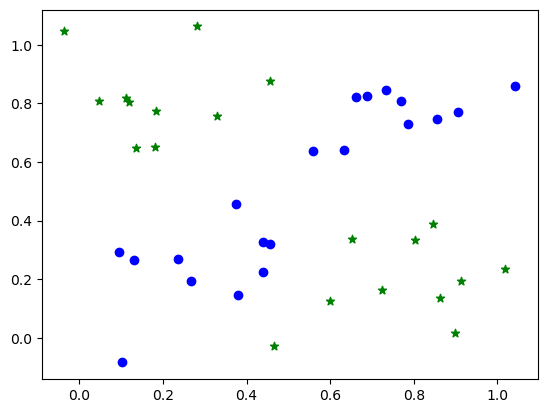

┌ Warning: Performing scalar operations on GPU arrays: This is very slow, consider disallowing these operations with `allowscalar(false)`
└ @ GPUArrays C:\Users\jbere\.julia\packages\GPUArrays\JqOUg\src\host\indexing.jl:43


In [5]:
#Generate XOR Data
function real_data(N::Int, modes::Int, σ::Float64)
    μ₁ = [0.25, 0.25]
    μ₂ = [0.25, 0.75]
    μ₃ = [0.75, 0.75]
    μ₄ = [0.75, 0.25]
    #μ₅ = [1.25, 1.25]
    #μ₆ = [1.25, 1.75]
    #μ₇ = [1.75, 1.75]
    #μ₈ = [1.75, 1.25]
    μ = [μ₁, μ₂, μ₃, μ₄]
    Σ = [[σ, 0] [0, σ]]
    
    all_samples = CUDA.zeros(Float64, (N*modes, 2))
    classes = zeros(Int, (N*modes))
    
    for i = 1:modes
        dist = MvNormal(μ[i], Σ)
        sample = rand(dist, N)::Matrix
        #scatter(sample[1,:],sample[2,:])
        all_samples[(i-1)*N+1:i*N,:] = transpose(sample)
        classes[(i-1)*N+1:i*N] = fill(i, N)
        classes = float(classes)
    end
    return all_samples, classes
end
    
data_raw, classes = real_data(Int(N/4), 4, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]

plot_data(data_raw,classes)
data = transpose(data_raw)
size(data);

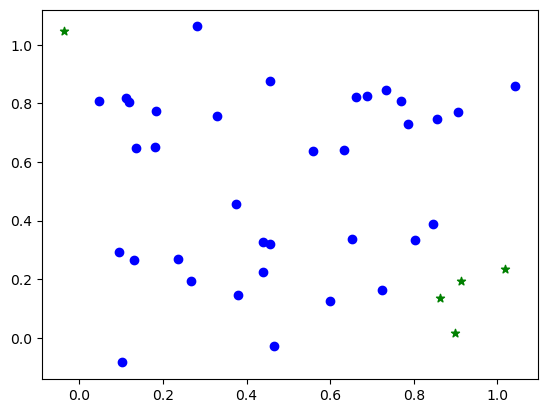

In [19]:
#Bayesian Neural Net
function G(x, Θ::AbstractVector, k::Int)
    if(typeof(x) == Float64)
        x = [x]
    end
    W₁, b₁, W₂, b₂ = unpack(Θ,k)
    nn = Chain(fmap(cu, Dense(W₁, b₁, σ)),
               fmap(cu, Dense(W₂, [b₂])))
    return nn(x)
end;

@dist k_count(r,p,min) = neg_binom(r,p) + 1

@gen function classifier(x::Array{Float64})
    σₖ = 100.0::Float64
    
    k ~ uniform_discrete(1,k_range) #Number of hidden nodes
    #k ~ k_count(1,0.5,1) #Shifted Negative Binomial
    #println(k)
    
    # Create the weight and bias vector.
    m = mₖ(k)
    μ = ones(m).*0
    Σ = Diagonal([σₖ for i=1:m])
    Θ ~ mvnormal(μ,Σ) #Coefficients of the polynomial
    
    #Return Network Scores for X
    scores = Flux.σ.(G(x,Θ,k))
    
    #Logistic Regression Likelihood
    y = zeros(length(x[1,:])) #Array to fill with class labels
    for j=1:length(x[1,:])
        y[j] = @trace(normal(scores[j]*1 + (1-scores[j])*0, 0.05), (:y,j))
    end
    return scores
    
end;

predictions = classifier(data)
#predictions = predictions |> cpu 
preds = data_labeller(predictions)
plot_data(data_raw,preds)

In [7]:
#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
for j in 1:length(classes)
    obs_master[(:y, j)] = classes[j] - 1
end;
obs = obs_master;

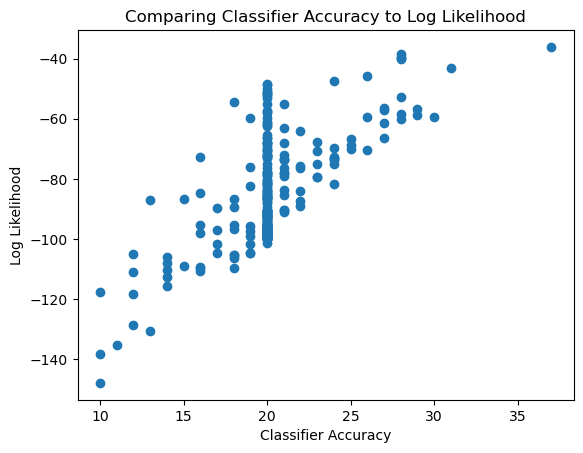

  11.179 ms (1975 allocations: 72.70 KiB)
681


In [22]:
#Plot of Log Likelihood Scores
scores = []
accs = []
ks = []
(best_trace,) = generate(classifier, (data,), obs)
best_score = get_score(best_trace)/length(classes)
best_Θ = best_trace[:Θ]
best_k = best_trace[:k]

best_pred_y = G(data,best_Θ,best_k)
#best_pred_y = best_pred_y |> cpu
best_pred_labels = data_labeller(best_pred_y)
best_acc = sum([best_trace[(:y,i)] == best_pred_labels[i] for i=1:length(classes)])/length(classes)

function likelihood!(best_acc)
    #for i in 1:2
    (trace,) = generate(classifier, (data,), obs)

    Θ = trace[:Θ]
    k = trace[:k]
    pred_y = G(data,Θ,k)
    #pred_y = pred_y |> cpu
    pred_labels = data_labeller(pred_y)

    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    score = get_score(trace)/length(classes)
    #println(score)
    if acc > best_acc
        best_score = score
        best_trace = trace
        best_acc = acc
        best_pred_labels = pred_labels
    end
    push!(scores,score)
    push!(accs,acc)
    push!(ks, k)
    #end
end

@btime for i=1:1
    likelihood!(best_acc)
end
println(length(scores))

scatter(accs,scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");

In [ ]:
#Plot of Log Likelihood Scores
scores = []
accs = []
ks = []
(best_trace,) = generate(classifier, (data,), obs)
best_score = get_score(best_trace)/length(classes)
best_Θ = best_trace[:Θ]
best_k = best_trace[:k]

best_pred_y = G(data,best_Θ,best_k)
best_pred_y = best_pred_y |> cpu
best_pred_labels = data_labeller(best_pred_y)
best_acc = sum([best_trace[(:y,i)] == best_pred_labels[i] for i=1:length(classes)])/length(classes)

function likelihood!(best_acc)
    #for i in 1:2
    (trace,) = generate(classifier, (data,), obs)

    Θ = trace[:Θ]
    k = trace[:k]
    pred_y = G(data,Θ,k)
    pred_y = pred_y |> cpu
    pred_labels = data_labeller(pred_y)

    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    score = get_score(trace)/length(classes)
    #println(score)
    if acc > best_acc
        best_score = score
        best_trace = trace
        best_acc = acc
        best_pred_labels = pred_labels
    end
    push!(scores,score)
    push!(accs,acc)
    push!(ks, k)
    #end
end

@btime for i=1:100
    likelihood!(best_acc)
end
println(length(scores))

scatter(accs,scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier Accuracy")
plt.ylabel("Log Likelihood");

In [ ]:
traces = []
acc = []
ks = []

function within_dimension(trace, iters)
    for i=1:iters
        (trace, accepted) = hmc(trace, select(:Θ), L=10, eps=0.03, check=false, observations=obs)
        #println("Within dimension: $(trace[:k])")
        push!(traces, trace)
        push!(acc, accepted)
    end
    return trace
end

function across_dimension(trace, iters, obs)
    selection = select(:Θ,:k)
    
    args = get_args(trace)
    argdiffs = map((_) -> NoChange(), args)
    (new_trace, weight) = regenerate(trace, args, argdiffs, selection)
    test = true
    
    for i=1:500
        (new_trace, accepted) = hmc(new_trace, select(:Θ), L=10, eps=0.01, check=false, observations=obs)
        accepted && (test = false)
    end
    
    test && println("Nothing accepted")
    
    score1 = exp(get_score(trace)/length(data))
    score2 = exp(get_score(new_trace)/length(data))
    score = score2/score1
    #println(score)
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = new_trace
        new_k = trace[:k]
        println("New k accepted! Current k: $(new_k)")
        push!(acc,true)
    else
        accepted = false
        push!(acc,false)
    end
    
    obs = obs_master
    obs[:k] = trace[:k]
        
    push!(traces, trace)
    push!(acc, accepted)
    return trace, trace[:k]
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    k = obs[:k]
    println("Beginning RJMCMC. Starting k: $k")
    #@showprogress 1 "Sampling..." for i = 1:iters
    for i=1:iters
        if i%500 == 0
            println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
        end
        
        if rand(Uniform(0,1)) > 0.95
            (trace, k) = across_dimension(trace, 1, obs)
        else
            (trace) = within_dimension(trace, 1)
        end
        push!(ks, k)
    end
    println("Finished")
end
 
starting_trace = best_trace
#(starting_trace,) = generate(classifier, (data,), obs)
obs[:k] = starting_trace[:k]
rjmcmc(starting_trace,5000);

In [9]:
function sequential_add!(y, x)
    for i in eachindex(y, x)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y, 2)
sequential_add!(y, x)
@test all(y .== 3.0f0)

Test Passed

In [10]:
function parallel_add!(y, x)
    Threads.@threads for i in eachindex(y, x)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y, 2)
parallel_add!(y, x)
@test all(y .== 3.0f0)

Test Passed

In [11]:
@btime sequential_add!($y, $x)

  253.199 μs (0 allocations: 0 bytes)


In [12]:
@btime parallel_add!($y, $x)

  177.000 μs (23 allocations: 3.34 KiB)


In [14]:
#GPUS
x_d = CUDA.fill(1.0f0, N)  # a vector stored on the GPU filled with 1.0 (Float32)
y_d = CUDA.fill(2.0f0, N)  # a vector stored on the GPU filled with 2.0
y_d .+= x_d
@test all(Array(y_d) .== 3.0f0)

┌ Warning: `Target(triple::String)` is deprecated, use `Target(; triple = triple)` instead.
│   caller = ip:0x0
└ @ Core :-1


Test Passed

In [19]:
function add_broadcast!(y, x)
    CUDA.@sync y .+= x
    return
end

@btime add_broadcast!($y_d, $x_d)

  197.200 μs (69 allocations: 1.88 KiB)


In [17]:
function gpu_add1!(y, x)
    for i = 1:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y_d, 2)
@cuda gpu_add1!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [18]:
function bench_gpu1!(y, x)
    CUDA.@sync begin
        @cuda gpu_add1!(y, x)
    end
end

@btime bench_gpu1!($y_d, $x_d)

  146.722 ms (47 allocations: 1.23 KiB)


In [20]:
function gpu_add2!(y, x)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

fill!(y_d, 2)
@cuda threads=256 gpu_add2!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

Test Passed

In [22]:
function bench_gpu2!(y, x)
    CUDA.@sync begin
        @cuda threads=256 gpu_add2!(y, x)
    end
end

@btime bench_gpu2!($y_d, $x_d)

  1.322 ms (47 allocations: 1.23 KiB)


In [23]:
function gpu_add3!(y, x)
    index = (blockIdx().x - 1) * blockDim().x + threadIdx().x
    stride = blockDim().x * gridDim().x
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return
end

numblocks = ceil(Int, N/256)

fill!(y_d, 2)
@cuda threads=256 blocks=numblocks gpu_add3!(y_d, x_d)
@test all(Array(y_d) .== 3.0f0)

function bench_gpu3!(y, x)
    numblocks = ceil(Int, length(y)/256)
    CUDA.@sync begin
        @cuda threads=256 blocks=numblocks gpu_add3!(y, x)
    end
end

@btime bench_gpu3!($y_d, $x_d)

  177.900 μs (52 allocations: 1.31 KiB)


In [24]:
function gpu_add2_print!(y, x)
    index = threadIdx().x    # this example only requires linear indexing, so just use `x`
    stride = blockDim().x
    @cuprintln("thread $index, block $stride")
    for i = index:stride:length(y)
        @inbounds y[i] += x[i]
    end
    return nothing
end

@cuda threads=16 gpu_add2_print!(y_d, x_d)
synchronize()

thread 1, block 16
thread 2, block 16
thread 3, block 16
thread 4, block 16
thread 5, block 16
thread 6, block 16
thread 7, block 16
thread 8, block 16
thread 9, block 16
thread 10, block 16
thread 11, block 16
thread 12, block 16
thread 13, block 16
thread 14, block 16
thread 15, block 16
thread 16, block 16
